# Natural Language Processing   

Mini-Challenge 1 (LE3-LE5)   
Yannic & Ben  


# Aufgabe

You evaluate 2 different classification systems on a text classification task (examples below). You argument why you chose these systems for that case and you build, train and evaluate the system. You also do a thorough error analysis and propose theories on how to improve the systems, especially also by analysing individual cases and comparing the predictions of each system. At least one of the systems is based on a fine-tuned deep learning model.

Here you can use data from shared tasks, such as semeval, kaggle, codalab or paperwithcode for text classification.

You can submit as a group of 2 but each one has to have a significant contribution. Submission is given as a gitlab repo. I will track with the commit history if there was  a significant contribution from each participant. The repo should include the report, a python notebook to reproduce the results and a wiki with a journal or git issues that document the progress of your mini-challenge.

Since many parts of code can be online, the most important part of the submission will be the report and evaluation of the results. In the report you describe which system you used, which are the theory behind it and why you chose it. The evaluation you describe the metric chose, why this metric is good for the use case and discuss the results of the experiments and some predictions on individual test samples. Bonus points will be given if you show, that you implemented the systems yourself, and the progress/errors are documented through commits.

ADDENDUM: The classification systems can be for example tf-idf-svm, cnns or transformers, see https://gitlab.fhnw.ch/fernando.benites/npr-21-fs/-/tree/master/text_classification/20news_group for an applied example. There are other ways to go, and I am open for suggestions. Please try to understand the systems, this can be handy in the error analysis/evaluation/report or in the exam. Don't use the 20newsgroup dataset. The repo will be used in the deep dive and so this dataset is already "taken". If you receive a 404 on the repo, please contact me, I'll add you to the repo, then it should work.

Some other starting points:

https://lionbridge.ai/articles/using-deep-learning-for-end-to-end-multiclass-text-classification/

BETTER: https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

GOOD: https://colab.research.google.com/github/patrickvankessel/AAPOR-Text-Analysis-2019/blob/master/Tutorial.ipynb#scrollTo=9wJQJUDHkM5w

BAD: https://medium.com/@qempsil0914/machine-learning-nlp-text-classification-with-amazon-review-data-using-python3-step-by-step-3fb0cc0cecc1

https://paperswithcode.com/task/text-classification

https://fbenites.github.io/GermEval/

https://medium.com/analytics-vidhya/fine-tuning-bert-language-model-to-get-better-results-on-text-classification-3dac5e3c348e

https://github.com/Shivampanwar/Bert-text-classification/blob/master/bert_language_model_with_sequence_classification.ipynb


# Libraries importieren

In [1]:
# Standard Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score

# nltk imports
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ben\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Datensatz einlesen

Dieser Datensatz enthält Zusammenfassungen von 16.559 Büchern, die aus Wikipedia extrahiert wurden, zusammen mit abgeglichenen Metadaten aus Freebase, einschließlich Autor, Titel und Genre des Buches.

Relevant für die npr Text Classification Minichallenge-1  sind die Spalten "genres" und "summary". 

In [2]:
# Read booksumaries.txt Dataset
df = pd.read_csv('data/booksummaries.txt', 
                 sep="\t", 
                 header=None, 
                 names=["wikipedia_id", "freebase_id", "book_title", "book_author", "pub_date","genres","summary"],
                 dtype={"wikipedia_id": np.int32, "freebase_id": str, "book_title": str, "book_author": str, "pub_date": str, "genres": str, "summary": str})

df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wikipedia_id  16559 non-null  int32 
 1   freebase_id   16559 non-null  object
 2   book_title    16559 non-null  object
 3   book_author   14177 non-null  object
 4   pub_date      10949 non-null  object
 5   genres        12841 non-null  object
 6   summary       16559 non-null  object
dtypes: int32(1), object(6)
memory usage: 841.0+ KB


,wikipedia_id,freebase_id,book_title,book_author,pub_date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


# Data Wrangling

Beim Data Wrangling wurden Funktionen geschrieben, die unseren Datensatz bereinigen. In einem späteren Abschnitt analysieren wir die Daten vor und nach der Bereinigung.

Hier wichtig sind dabei folgende Funktionen für das Data Wrangling:

- extract_genres: Extrahiert die Genres aus dem Datensatz und gibt diese als Liste zurück.
- drop_na_duplicates: Entfernt alle Zeilen, die NaN Werte enthalten und entfernt Duplikate.
- wrangle_genre: Entfernt alle Genre die weniger als x mal vorkommen.
- wrangle_summary: Entfernt alle Zusammenfassungen, die weniger als x Percentil enthalten.
- analyze_dataframe: Gibt einen kleinen Vergleich zwischen dem Datensatz vor und nach dem Data Wrangling aus, sowie die Anzahl der Genres und deren möglichen Kombinationen.

In [3]:
# function to extract genres
def extract_genres(genre_str: str):
    """
    Extract the genres from the given string.

    Parameters:
    genre_str (str): input string

    Returns:
    list: list of genres
    """
    try:
        genre_data = json.loads(genre_str)
        return list(genre_data.values())
    except:
        (json.decoder.JSONDecodeError, TypeError)
        return np.nan
    
# function to drop na rows and duplicates
def drop_na_duplicates(df: pd.DataFrame):
    """
    Drop rows with missing values in the genres and summary columns and drop duplicate rows.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with missing values and duplicates dropped
    """
    return df.dropna(subset=['genres', 'summary']).drop_duplicates(subset=["summary"]).reset_index(drop=True)

# function to wrangle genres
def wrangle_genres(df, minimum_genre_occurence=5):
    """
    Wrangle the genres column of the given dataframe, removing rows with genres that occur less than the given minimum_genre_occurence.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with genres wrangled
    """
    # create copy of dataframe to avoid changing the original
    df_wrangle = df.copy()

    # Turn genres into set
    df_wrangle['genres'] = df_wrangle['genres'].apply(set)

    # Convert genres sets to strings to count occurrences
    df_count = pd.DataFrame(df_wrangle['genres'].value_counts()).reset_index()
    
    # Filter rows where genres occur more than 5 times
    selected_rows = df_count[df_count['count'] > minimum_genre_occurence]['genres']
    df_wrangle = df_wrangle[df_wrangle['genres'].isin(selected_rows)]
    
    # Turn back into list
    df_wrangle['genres'] = df_wrangle['genres'].apply(list)

    return df_wrangle

# function to wrangle summary
def wrangle_summary(df, minimum_quantile=0.01):
    """
    Wrangle the summary column of the given dataframe, removing rows with summaries that are longer than the given minimum_quantile.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with summaries wrangled
    """
    # create copy of dataframe to avoid changing the original
    df_wrangle = df.copy()

    # Filter rows where summaries are shorter than 10% quantile
    df_wrangle = df_wrangle[df_wrangle['summary'].str.len() > df_wrangle['summary'].str.len().quantile(minimum_quantile)]

    return df_wrangle

# function to analyze the difference between two DataFrames
def analyze_dataframe(df, df_wrangled):
    """
    Analyze the difference between two DataFrames.

    Parameters:
    df (DataFrame): original DataFrame
    df_wrangled (DataFrame): wrangled DataFrame

    Returns:
    dict: a dictionary containing the analysis results
    """
    analysis_results = {}
    
    # Calculate the number of dropped rows
    num_dropped_rows = df.shape[0] - df_wrangled.shape[0]
    analysis_results["Number of dropped rows"] = num_dropped_rows
    
    # Calculate the relative number of dropped rows in percent and round to 2 decimal places
    relative_dropped_percent = round((num_dropped_rows / df.shape[0]) * 100, 2)
    analysis_results["Relative number of dropped rows in percent"] = f"{relative_dropped_percent}%"
    
    # Calculate the number of unique genres
    num_unique_genres = df_wrangled['genres'].explode().nunique()
    analysis_results["Number of unique genres"] = num_unique_genres

    # copy Dataframe to avoid changing the original
    df_wrangle = df_wrangled.copy()

    # count unique combinations of elemnts in lists within a specified DataFrame column
    df_wrangle['genres'] = df_wrangle['genres'].apply(lambda x: set(sorted(x)) if isinstance(x, list) else x)
    
    # Count occurrences of each unique combination
    combination_counts = df_wrangle['genres'].value_counts().reset_index().shape[0]
    analysis_results["Number of unique genre combinations"] = combination_counts
    
    return analysis_results

# copy Dataframe to avoid changing the original
df_unwrangled = df.copy()

# Start Data Wrangling
# apply extract_genres function to the genres column
df_unwrangled['genres'] = df_unwrangled['genres'].apply(extract_genres)

# create a copy for later analysis
df_unwrangled_analysis = df_unwrangled.copy()

# drop na rows and duplicates
df_unwrangled = drop_na_duplicates(df=df_unwrangled)

# wrangle genres
df_unwrangled = wrangle_genres(df=df_unwrangled, minimum_genre_occurence=5)

# wrangle summary
df_wrangled = wrangle_summary(df=df_unwrangled, minimum_quantile=0.01)

# display wrangled dataframe
display(df_wrangled)

# analyze the difference between the original and the wrangled dataframe
print(analyze_dataframe(df=df, df_wrangled=df_wrangled))



,wikipedia_id,freebase_id,book_title,book_author,pub_date,genres,summary
6,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Speculative fiction, Science Fiction]","Living on Mars, Deckard is acting as a consul..."
7,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"[Speculative fiction, Science Fiction]",Beginning several months after the events in ...
9,6020,/m/01t5z,Crash,J. G. Ballard,1973,"[Fiction, Novel, Speculative fiction]",The story is told through the eyes of narrato...
10,6628,/m/01y92,Children of Dune,Frank Herbert,1976,"[Fiction, Children's literature, Speculative f...",Nine years after Emperor Paul Muad'dib walked...
12,6630,/m/01yb0,Chapterhouse Dune,Frank Herbert,1985-04,"[Fiction, Children's literature, Speculative f...",The situation is desperate for the Bene Gesse...
...,...,...,...,...,...,...,...
12811,36126792,/m/044psh,Gates of Paradise,V. C. Andrews,1989-06,"[Young adult literature, Gothic fiction]","A novel about Annie Stonewall, the daughter o..."
12812,36372465,/m/02vqwsp,The Third Lynx,Timothy Zahn,2007,[Science Fiction],The story starts with former government agent...
12813,36534061,/m/072y44,Remote Control,Andy McNab,1997,"[Thriller, Suspense, Fiction]",The series follows the character of Nick Ston...
12814,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...


{'Number of dropped rows': 6675, 'Relative number of dropped rows in percent': '40.31%', 'Number of unique genres': 57, 'Number of unique genre combinations': 228}


# Explorative Daten Analyse

**Fehlende Werte**   
In einem ersten Schritt visualisieren wir mittels einem Barplot die Fehlenden Werte für jede Spalte vor und nach dem Data Wrangling. Dabei stellen wir fest, dass es 3718 Werte gibt, die in der Spalte "genres" fehlen. Da wir diese Spalte für die Text Classification benötigen, wurden diese entfernt. Die anderen Spalten in denen fehlende Werte vorhanden sind, ist für unsere Text Classification nicht relevant und wurden deshalb auch nicht berücksichtigt beim Data Wrangling.


**Anzahl Genres**   
Ein Buch kann ein bis mehrere Genre aufweisen. In der Spalte "genres" sind die Genres mit einem Komma getrennt. Wir haben die Anzahl Genres pro Buch gezählt und in einem Barplot visualisiert. Dabei haben wir festgestellt, dass es viele Bücher gab die mehrere Genre aufweisen können. Wir wissen durch die Funktion "anlazye_dataframe", dass wir 57 Genres haben. Jedoch kann ein Buch mehrere Genre aufweisen und haben somit 228 einzigartige kombinierte Genres. Weiter haben wir Genre entfernt, die weniger als 5 mal in unserem Datensatz vorkommen, um später bei der Klassifizierung eine bessere Performance zu erhalten. Die Visualisierung bei den Flop 5 Genres vor und nach dem Data Wrangling ist unten zu sehen.

**Anzahl Wörter**   
Weiter wurde auch die Spalte "summary" betrachtet und festgestellt, dass es manchmal Bücher gab die nur aus Sonderzeichen bestanden oder nur aus wenigen Worten, sprich ein Satz. Es wurden Bücher entfernt die weniger als 1 Percentil Länge aufweisen. Dies mit dem Hintergedanke, dass diese Bücher nicht aussagekräftig sind für die Text Classification, da sie zu kurz sind.



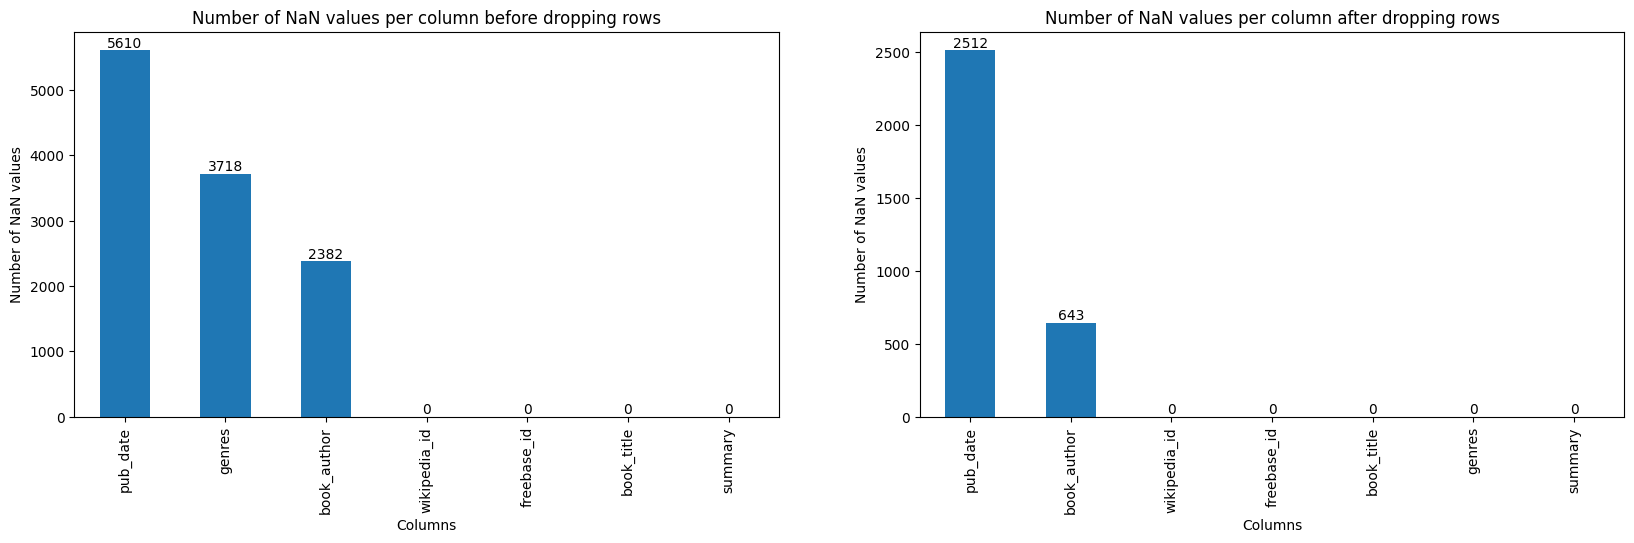

In [4]:
# befor and after data wrangling
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
df.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[0])
for index, value in enumerate(df.isna().sum().sort_values(ascending=False)):
    axes[0].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[0].set_title('Number of NaN values per column before dropping rows')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Number of NaN values')

df_wrangled.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[1])
for index, value in enumerate(df_wrangled.isna().sum().sort_values(ascending=False)):
    axes[1].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[1].set_title('Number of NaN values per column after dropping rows')
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Number of NaN values')
plt.show()

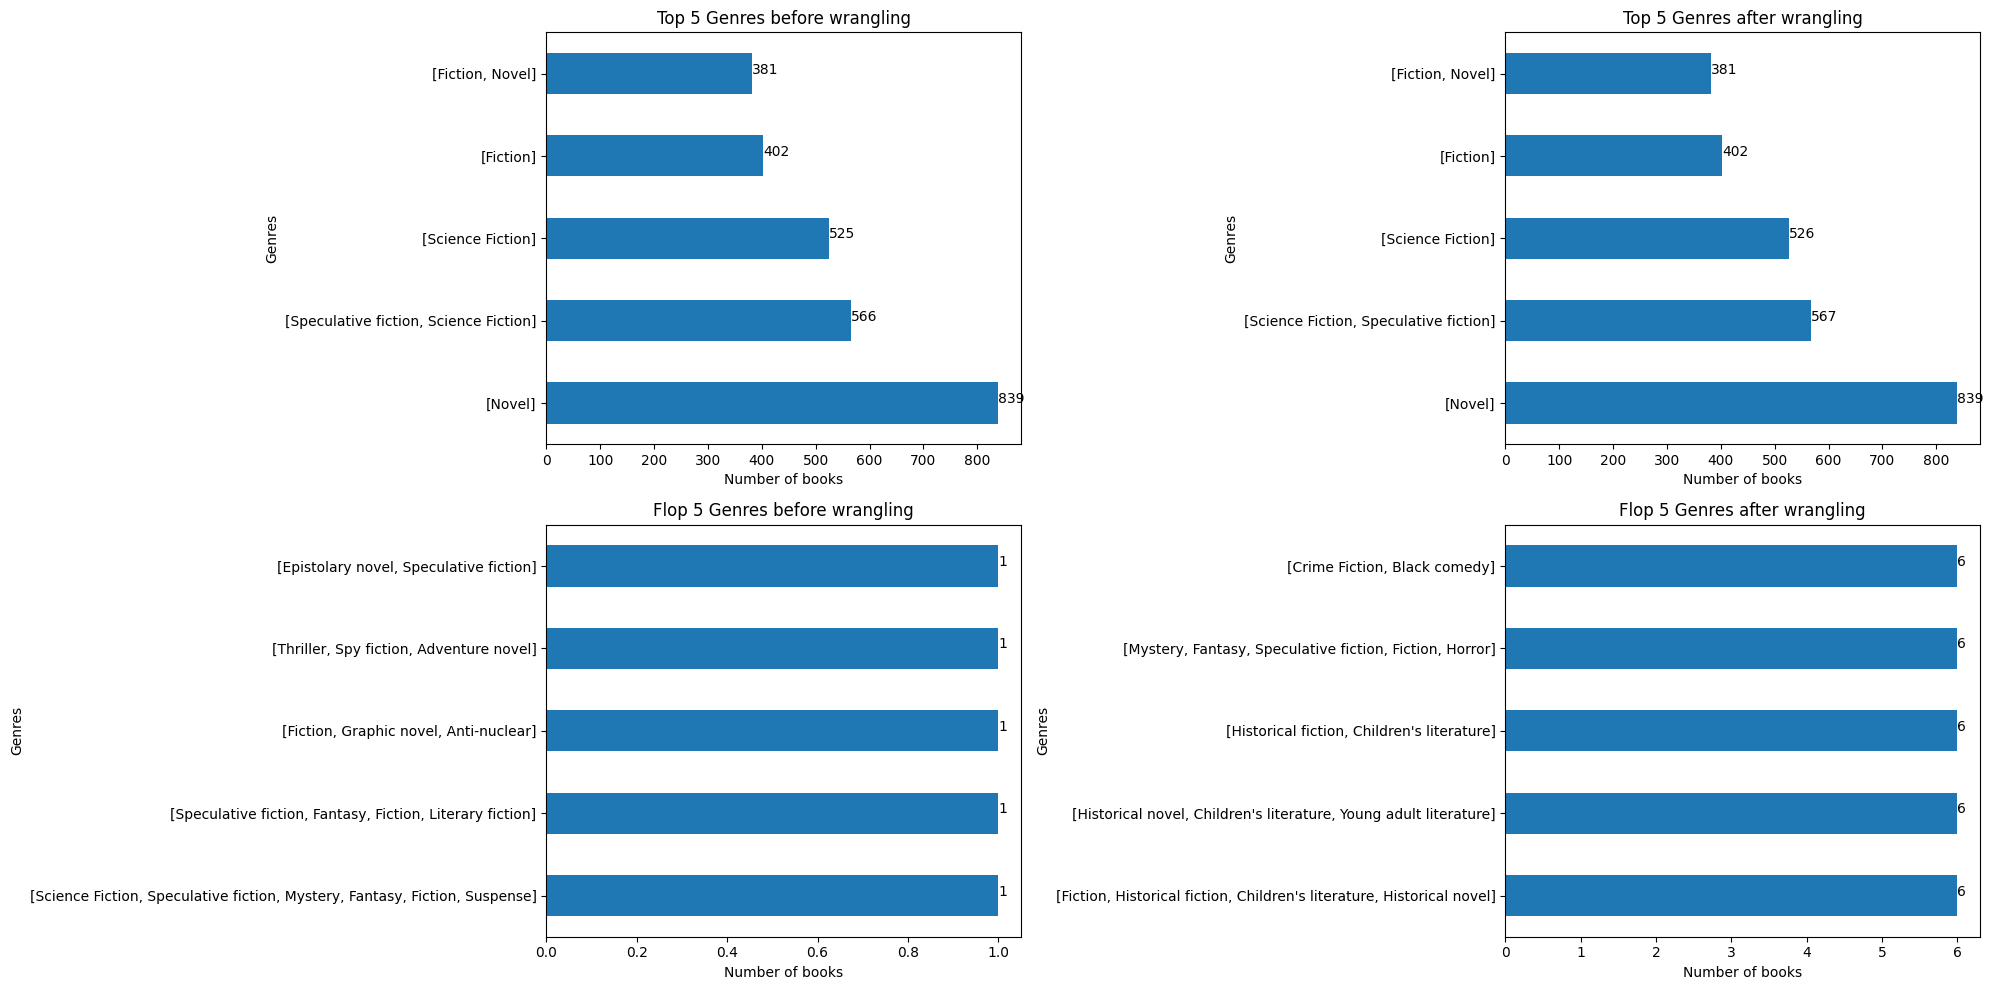

In [5]:
# Create 4 subplots for top 5 Genres and Flop 5 Genres for the df and df_wrangled
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
df_unwrangled["genres"].value_counts().head(n=5).plot(kind='barh', ax=axes[0, 0])
for index, value in enumerate(df_unwrangled["genres"].value_counts().head(n=5)):
    axes[0, 0].text(value, index, str(value))
axes[0, 0].set_title('Top 5 Genres before wrangling')
axes[0, 0].set_xlabel('Number of books')
axes[0, 0].set_ylabel('Genres')

df_unwrangled_analysis["genres"].value_counts().head(n=5).plot(kind='barh', ax=axes[0, 1])
for index, value in enumerate(df_unwrangled_analysis["genres"].value_counts().head(n=5)):
    axes[0, 1].text(value, index, str(value))
axes[0, 1].set_title('Top 5 Genres after wrangling')
axes[0, 1].set_xlabel('Number of books')
axes[0, 1].set_ylabel('Genres')

df_unwrangled_analysis["genres"].value_counts().tail(n=5).plot(kind='barh', ax=axes[1, 0])
for index, value in enumerate(df_unwrangled_analysis["genres"].value_counts().tail(n=5)):
    axes[1, 0].text(value, index, str(value))
axes[1, 0].set_title('Flop 5 Genres before wrangling')
axes[1, 0].set_xlabel('Number of books')
axes[1, 0].set_ylabel('Genres')

df_wrangled["genres"].value_counts().tail(n=5).plot(kind='barh', ax=axes[1, 1])
for index, value in enumerate(df_wrangled["genres"].value_counts().tail(n=5)):
    axes[1, 1].text(value, index, str(value))
axes[1, 1].set_title('Flop 5 Genres after wrangling')
axes[1, 1].set_xlabel('Number of books')
axes[1, 1].set_ylabel('Genres')

plt.tight_layout()
plt.show()


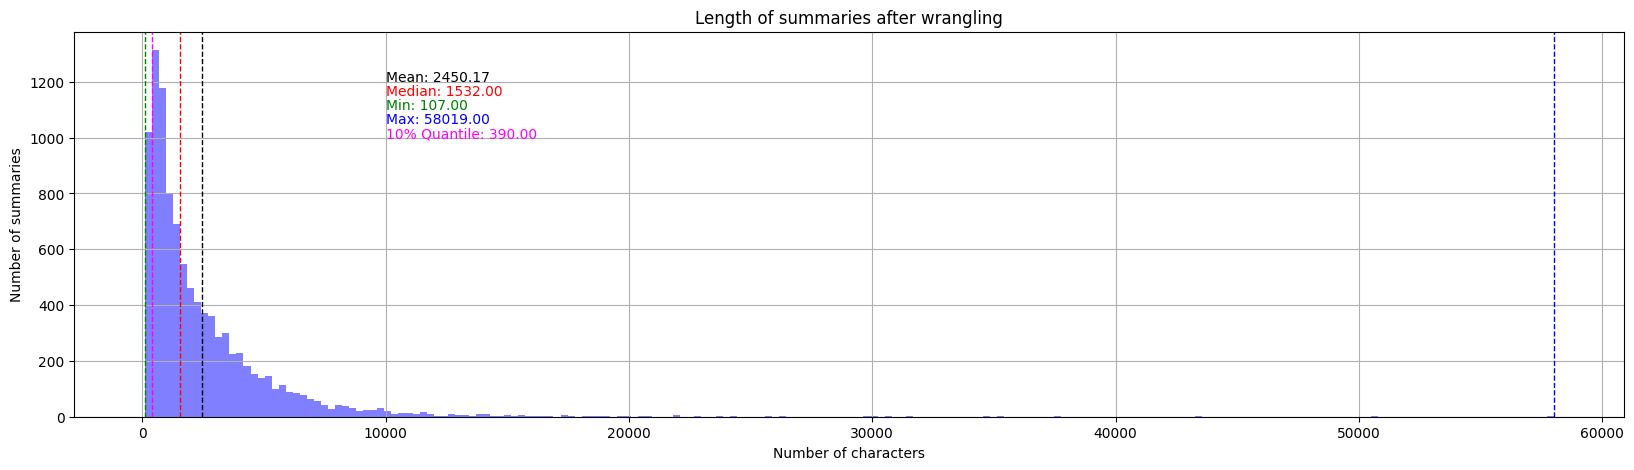

In [6]:
# create a histogram of the len of the summaries
df_wrangled['summary'].str.len().hist(figsize=(20, 5), bins=200, color='blue', alpha = 0.5)
plt.axvline(df_wrangled['summary'].str.len().mean(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().min(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().max(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().quantile(0.1), color='magenta', linestyle='dashed', linewidth=1)

mean_length = df_wrangled['summary'].str.len().mean()
median_length = df_wrangled['summary'].str.len().median()
min_length = df_wrangled['summary'].str.len().min()
max_length = df_wrangled['summary'].str.len().max()
quantile_10 = df_wrangled['summary'].str.len().quantile(0.1)

# add labels from axvline
plt.text(10000, 1200, f'Mean: {mean_length:.2f}', fontsize=10, color='black')
plt.text(10000, 1150, f'Median: {median_length:.2f}', fontsize=10, color='r')
plt.text(10000, 1100, f'Min: {min_length:.2f}', fontsize=10, color='g')
plt.text(10000, 1050, f'Max: {max_length:.2f}', fontsize=10, color='b')
plt.text(10000, 1000, f'10% Quantile: {quantile_10:.2f}', fontsize=10, color='magenta')

plt.title('Length of summaries after wrangling')
plt.xlabel('Number of characters')
plt.ylabel('Number of summaries')
plt.show()

# Data NLP Pre-processing

Für die Text Klassifikation wurden folgende Pre-Processing Schritte durchgeführt:
- lower: Alle Wörter wurden in Kleinbuchstaben umgewandelt.
- punctuation: Alle Satzzeichen wurden entfernt.
- stopwords: Alle Stopwords wurden entfernt.
- lemmatization: Alle Wörter wurden auf ihren Wortstamm zurückgeführt.
- tokenization: Alle Wörter wurden in Tokens umgewandelt.

Alle diese Schritte sind unter der Funktion preprocess_summary zusammengefasst, welche uns eine Liste mit den vorverarbeiteten Texten zurückgibt.

In einem weiteren Schritt wurde noch ein Pos-Tag durchgeführt, um die Wortarten zu bestimmen. Dies mit dem Hintergedanken, dass wir später die Wortarten ebenfalls als ein weiteres Feature verwenden können.


In [7]:
# select the relevant columns
df_nlp = df_wrangled[['genres', 'summary']].copy()

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))

# preprocess Summary column and add it to the dataframe
def preprocess_summary(summary_text: str):
    # case folding to lower case 
    summary_text = summary_text.lower()
    # remove punctuation, kommas, dots, and other special characters
    summary_text = summary_text.translate(str.maketrans('', '', string.punctuation))
    # remove stopwords
    summary_text = [word for word in summary_text.split() if word not in stop_words]
    # lemmatize words
    summary_text = [WordNetLemmatizer().lemmatize(word) for word in summary_text]
    # Tokenize
    summary_text = word_tokenize(" ".join(summary_text))
    return summary_text

# apply preprocess function to Summary column
df_nlp['tokens'] = df_nlp['summary'].apply(preprocess_summary)

# display dataframe
display(df_nlp)

,genres,summary,tokens
6,"[Speculative fiction, Science Fiction]","Living on Mars, Deckard is acting as a consul...","[living, mar, deckard, acting, consultant, mov..."
7,"[Speculative fiction, Science Fiction]",Beginning several months after the events in ...,"[beginning, several, month, event, blade, runn..."
9,"[Fiction, Novel, Speculative fiction]",The story is told through the eyes of narrato...,"[story, told, eye, narrator, james, ballard, n..."
10,"[Fiction, Children's literature, Speculative f...",Nine years after Emperor Paul Muad'dib walked...,"[nine, year, emperor, paul, muaddib, walked, d..."
12,"[Fiction, Children's literature, Speculative f...",The situation is desperate for the Bene Gesse...,"[situation, desperate, bene, gesserit, find, t..."
...,...,...,...
12811,"[Young adult literature, Gothic fiction]","A novel about Annie Stonewall, the daughter o...","[novel, annie, stonewall, daughter, heaven, ca..."
12812,[Science Fiction],The story starts with former government agent...,"[story, start, former, government, agent, fran..."
12813,"[Thriller, Suspense, Fiction]",The series follows the character of Nick Ston...,"[series, follows, character, nick, stone, exmi..."
12814,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,"[reader, first, meet, rapp, covert, operation,..."


# Feature Extraction

Als Feature Extraction wurde jedem Token noch ein Pos-Tag durchgeführt, um die Wortarten zu bestimmen. 
Diese sind in der Spalte "POS-Tag" zu finden.

Einfach haltshalber wurde aus unserem Target, dem "genres" ein One-Hot-Encoding durchgeführt, da ein Buch mehrere Klassen haben kann. Weiter wird der Datensatz nach dem POS-Tagging in ein 80% Train und 20 % Test Datensatz aufgeteilt, um später damit unser Modelle zu trainieren und evaluieren zu können. 


In [8]:
# POS-Tagging
def pos_tag_text(tokens: list):
    pos_tagged = nltk.pos_tag(tokens)
    # Returning the tags as a string
    return pos_tagged

# apply pos_tag_text function to Summary column
#['POS-Tag'] = df_nlp['tokens'].apply(pos_tag_text)

# turn tokens from list to str
df_nlp['tokens'] = df_nlp['tokens'].apply(lambda x: " ".join(x))

# select relevant columns for classification
#df_preprocessed = df_nlp[['genres', 'tokens', 'POS-Tag']].copy()
df_preprocessed = df_nlp[['genres', 'tokens']].copy()

# display DataFrame
display(df_preprocessed)

,genres,tokens
6,"[Speculative fiction, Science Fiction]",living mar deckard acting consultant movie cre...
7,"[Speculative fiction, Science Fiction]",beginning several month event blade runner dec...
9,"[Fiction, Novel, Speculative fiction]",story told eye narrator james ballard named au...
10,"[Fiction, Children's literature, Speculative f...",nine year emperor paul muaddib walked desert b...
12,"[Fiction, Children's literature, Speculative f...",situation desperate bene gesserit find target ...
...,...,...
12811,"[Young adult literature, Gothic fiction]",novel annie stonewall daughter heaven casteel ...
12812,[Science Fiction],story start former government agent frank comp...
12813,"[Thriller, Suspense, Fiction]",series follows character nick stone exmilitary...
12814,"[Thriller, Fiction]",reader first meet rapp covert operation iran d...


# Model Training & Evaluation

Anschliessend wurde ein TF-IDF Vectorizer angewendet, um die Wörter in Vektoren umzuwandeln. Dabei repräsentieren die Zeilen der Matrix unsere Bücher Zusammenfassung und die Spalten unser Wortschatz. Die Werte in der Matrix sind die TF-IDF Werte. Beim TF-IDF wurde dabei "1-gramm" und "2-gramm" verwendet.

Die Funktion perform_classification nimmt als Input Wert die preprocessed Tokens und One-Hot-Encodeter Target. Die Funktion ermoeglicht es auch einen n_split auszuwaehlen um Cross Validation durchzufuehren mit dem bestimmten Estimator. Als Output erhalten wir ein Dictionary welches als Key Woerter die Wahrscheinlichkeits Matrizen in einer Liste enthaelt und auch die y_test Matrizen. Diese werden dann spaeter in der Funktion calculate_score() weiter verarbeitet mit unterschiedlichen Thresholds.

In [9]:
def perform_classification(X, 
                           Y, 
                           ngram_range=(1, 1), 
                           estimator=RandomForestClassifier(random_state=42, n_jobs=-1), 
                           n_splits=5, 
                           random_state=42,
                           verbose=0):
    """
    Perform cross-validation for the given data.

    Parameters:
    X (array-like): input data
    Y (array-like): target data
    ngram_range (tuple): range of ngrams to use
    estimator (estimator): estimator to use
    n_splits (int): number of splits to use
    random_state (int): random state to use
    verbose (int): verbosity level

    Returns:
    dict: a dictionary containing the results
    """
    
    # Set up KFold cross-validation
    kf = KFold(n_splits=n_splits, 
               random_state=random_state, 
               shuffle=True)

    # Create a TfidfVectorizer with specified ngram_range
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)

    # Create a classifier with specified estimator
    clf = OneVsRestClassifier(estimator=estimator, 
                              n_jobs=-1, 
                              verbose=verbose)

    y_pred_probas_list = []
    y_test_list = []

    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Store test labels
        y_test_list.append(Y_test)

        # Vectorization
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        # Train the classifier
        clf.fit(X_train_tfidf, Y_train)

        # Get the probability score for each class
        Y_pred_proba = clf.predict_proba(X_test_tfidf)

        # Store probability scores
        y_pred_probas_list.append(Y_pred_proba)

    results = {
        'y_pred_probas_list': y_pred_probas_list,
        'y_test_list': y_test_list
    }
    
    return results

def calculate_scores(results, threshold=0.3, f1_metric_type="micro", verbose=0):
    """
    Calculate F1 scores based on the results from perform_classification and a given threshold.
    
    Parameters:
    - results: Output from perform_classification function
    - threshold: Threshold for classifying predicted probabilities
    - f1_metric_type: Type of F1 metric ("micro", "macro", "weighted")
    - verbose: Verbosity level
    
    Returns:
    - Dictionary with average F1 score, standard deviation of F1 score, and F1 scores for each fold
    """

    y_pred_probas_list = results['y_pred_probas_list']
    y_test_list = results['y_test_list']
    
    f1_scores_list = []

    for Y_test, Y_pred_proba in zip(y_test_list, y_pred_probas_list):
        # Convert the probability score into binary matrix
        Y_pred = (Y_pred_proba >= threshold).astype(int)

        # Evaluate the model using F1 score with selected average parameter
        f1_score_val = f1_score(Y_test, 
                                Y_pred, 
                                average=f1_metric_type, 
                                zero_division=1)
        
        # Store the F1 score
        f1_scores_list.append(f1_score_val)

    # Average F1 score across all folds
    avg_f1_score = np.mean(f1_scores_list)
    
    # Calculate std deviation of F1 score across all folds
    std_f1_score = np.std(f1_scores_list)

    # verbose
    if verbose:
        print(f"Average F1 Score ({f1_metric_type.capitalize()} and threshold {str(threshold)}):", avg_f1_score)
        print(f"Std Deviation of F1 Score ({f1_metric_type.capitalize()} and threshold {str(threshold)}):", std_f1_score)

    scores = {
        'f1_scores': f1_scores_list,
        'average_f1_score': avg_f1_score,
        'std_f1_score': std_f1_score
    }

    return scores

In [10]:
# Convert target variable to binary matrix *one-hot encoding*
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_preprocessed['genres'])
X = df_preprocessed['tokens'].values

# Display the shape of X and Y
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

# print the classes
print("Classes:", mlb.classes_)
print("Number of classes:", len(mlb.classes_))

# print first 5 rows of Y
print("First 2 rows of Y:")
print(Y[:2])

# print first 5 rows of X
print("First 2 rows of X:")
print(X[:2])

Shape of X: (9884,)
Shape of Y: (9884, 57)
Classes: ['Adventure' 'Adventure novel' 'Alternate history'
 'Autobiographical novel' 'Autobiography' 'Bildungsroman' 'Biography'
 'Black comedy' "Children's literature" 'Comedy' 'Comic book'
 'Comic novel' 'Crime Fiction' 'Detective fiction' 'Dystopia' 'Erotica'
 'Fantasy' 'Fiction' 'Gamebook' 'Gothic fiction' 'Graphic novel'
 'Hard science fiction' 'High fantasy' 'Historical fiction'
 'Historical novel' 'History' 'Horror' 'Literary fiction' 'Memoir'
 'Military science fiction' 'Mystery' 'Non-fiction' 'Novel' 'Novella'
 'Philosophy' 'Picture book' 'Play' 'Poetry' 'Psychological novel'
 'Role-playing game' 'Romance novel' 'Satire' 'Science Fiction'
 'Short story' 'Speculative fiction' 'Spy fiction' 'Suspense'
 'Sword and sorcery' 'Techno-thriller' 'Thriller' 'True crime' 'War novel'
 'Western' 'Western fiction' 'Whodunit' 'Wuxia' 'Young adult literature']
Number of classes: 57
First 2 rows of Y:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

## Random Forest Classifier & n_grams=(1, 1)

In [ ]:
# perform with ngram_range (1, 1)
results_rfc_ngram_1_1 = perform_classification(X=X,
                                      Y=Y,
                                      ngram_range=(1, 1),
                                      estimator=RandomForestClassifier(random_state=42),
                                      n_splits=5,
                                      random_state=42,
                                      verbose=0)

In [ ]:
# export results as dataframe
results_to_save = pd.DataFrame.from_dict(results_rfc_ngram_1_1, orient='index').T

# export as csv
results_to_save.to_csv("results/results_rfc_ngram_1_1.csv")

# create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 11)
f1_scores_avg = []
f1_scores_std = []

for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    scores = calculate_scores(results_rfc_ngram_1_1, threshold=threshold, f1_metric_type="micro")
    f1_scores_avg.append(scores["average_f1_score"])
    f1_scores_std.append(scores["std_f1_score"])

best_result = {
    "model": "Random Forest Classifier",
    "ngrams": "(1, 1)",
    "highest_f1_score": max(f1_scores_avg),
    "std_deviation": f1_scores_std[f1_scores_avg.index(max(f1_scores_avg))],
    "threshold": thresholds[f1_scores_avg.index(max(f1_scores_avg))]
    }

# create a dataframe
results_df = pd.DataFrame.from_dict(best_result, orient='index').T
display(results_df)

# plot the data with eror bars
plt.figure(figsize=(20, 12))
plt.errorbar(thresholds, f1_scores_avg, yerr=f1_scores_std, fmt='-o', 
             ecolor='orangered', capsize=5, color='blue', markersize=5, 
             linewidth=2, label='F1 Score Micro')
plt.title('F1 Score Micro for different thresholds \n (Random Forest Classifier, ngram_range=(1, 1))')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')

# customize the tick labels
plt.xticks(np.arange(0, 1.1, 0.1))

# add legend
plt.legend(loc='upper right')

# show plot
plt.show()

## Random Forest Classifier & n_grams=(1, 2)

In [ ]:
# perform with ngram_range (1, 2)
results_rfc_ngram_1_2 = perform_classification(X=X,
                                      Y=Y,
                                      ngram_range=(1, 2),
                                      estimator=RandomForestClassifier(random_state=42),
                                      n_splits=5,
                                      random_state=42,
                                      verbose=0)

In [ ]:
# export results as dataframe
results_to_save = pd.DataFrame.from_dict(results_rfc_ngram_1_2, orient='index').T

# export as csv
results_to_save.to_csv("results/results_rfc_ngram_1_2.csv")


# create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 11)
f1_scores_avg = []
f1_scores_std = []

for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    scores = calculate_scores(results_rfc_ngram_1_2, threshold=threshold, f1_metric_type="micro")
    f1_scores_avg.append(scores["average_f1_score"])
    f1_scores_std.append(scores["std_f1_score"])

best_result = {
    "model": "Random Forest Classifier",
    "ngrams": "(1, 2)",
    "highest_f1_score": max(f1_scores_avg),
    "std_deviation": f1_scores_std[f1_scores_avg.index(max(f1_scores_avg))],
    "threshold": thresholds[f1_scores_avg.index(max(f1_scores_avg))]
    }

# concat with previous results dataframe
results_df = pd.concat([results_df, pd.DataFrame.from_dict(best_result, orient='index').T])
display(results_df)

# Export results_df as csv
results_df.to_csv("results/best_results_tfidf_rfc.csv")

# plot the data with eror bars
plt.figure(figsize=(20, 12))
plt.errorbar(thresholds, f1_scores_avg, yerr=f1_scores_std, fmt='-o', 
             ecolor='orangered', capsize=5, color='blue', markersize=5, 
             linewidth=2, label='F1 Score Micro')
plt.title('F1 Score Micro for different thresholds \n (Random Forest Classifier, ngram_range=(1, 2))')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')

# customize the tick labels
plt.xticks(np.arange(0, 1.1, 0.1))

# add legend
plt.legend(loc='upper right')

# show plot
plt.show()

# Vergleich der Modelle

Wir Vergleichen nun den höchschten Score den wir erreicht haben mit dem TF-idf Random Forest Classifier mit n_grams (1,1) und (2, 2) und visualisieren diese in einem Barplot.

In [ ]:
# Read results from csv
best_result_tfidf_rfc = pd.read_csv("results/best_results_tfidf_rfc.csv", index_col=0)

df = best_result_tfidf_rfc.copy()

In [ ]:
'''
data = {
    'model': ['Random Forest Classifier', 'Random Forest Classifier'],
    'ngrams': ['(1, 1)', '(1, 2)'],
    'highest_f1_score': [0.546903, 0.541613],
    'std_deviation': [0.002764, 0.003407],
    'threshold': [0.2, 0.2]
}
df = pd.DataFrame(data)
df
'''

# Update y-axis labels
df['y_label'] = 'TF-idf ' + df['model'] + '\nn_grams = ' + df['ngrams'] + '\ntreshold = ' + df['threshold'].astype(str)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(df['y_label'], df['highest_f1_score'], xerr=df['std_deviation'], color='skyblue')
ax.set_xlabel('Highest F1 Score')
ax.set_title('Highest F1 Score with Standard Deviation')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add F1-score values at the center of the bars
for bar, f1_score in zip(bars, df['highest_f1_score']):
    ax.text(bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
            f'{f1_score:.6f}', va='center', ha='center')

plt.show()

# Deep Learning Model Transformer

Wir versuchen eine Genre-Klassifkation mit einem Deep Learning Model zu erreichen. Dazu verwenden wir ein BERT Model, welches wir mit der Huggingface Library verwenden.

## Libraries importieren

Hier importieren wir die wichtigsten Libraries die wir für das Deep Learning Model benötigen.

In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
print(torch.__version__)

from sklearn.metrics import jaccard_score
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCEWithLogitsLoss

import torch
from torch.nn import Sigmoid

import random

from tqdm import tqdm                                        


1.13.1+cu116


## CPU/GPU check

Hier überprüfen wir, ob uns eine GPU zur Verfügung steht und ob diese genügend Speicher hat.

In [12]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# Seed everything for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



Using device: cuda

NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Data PreProcessing

Damit wir mit dem Bert Transformer arbeiten können, müssen wir zuerst unsere Daten in ein passendes Format für den Bert Classifier bringen. Dazu gehört, dass wir unsere X_train und X_test Input jeweils tokensieren und auf eine länge von 512 Tokens verarbeiten. Falls eine Zusammenfassung weniger als 512 Tokens hat, so wird diese mit padding aufgefüllt. Bei längeren Zusammenfassungen werden diese auf 512 Tokens geschnitten. 


Folgende Parameter wurden von bert_tokenizer verwendet:
list(X_train)/list(X_test): Wandelt die Daten in eine Liste von Texten um, die tokenisiert werden sollen. Der Tokenizer verarbeitet diese Listen und erstellt die Token für jedes Element.

truncation=True: Dieser Parameter gibt an, dass alle Texte, die länger als die maximale Länge (max_length) sind, abgeschnitten werden sollen. Das bedeutet, dass Teile des Textes am Ende entfernt werden, um die maximale Länge einzuhalten.

padding=True: Stellt sicher, dass alle tokenisierten Ausgaben die gleiche Länge haben, indem sie mit Nullen (oder einem anderen spezifizierten Token) aufgefüllt werden, bis sie die maximale Länge erreichen. Dies ist notwendig, da Modelle wie BERT Eingaben erfordern, die in der Größe einheitlich sind.

max_length=512: Legt die maximale Sequenzlänge fest. Da BERT-Modelle auf eine bestimmte maximale Eingabelänge beschränkt sind (oft 512 Token), stellt dieser Parameter sicher, dass keine Eingabe diese Grenze überschreitet.

return_tensors="pt": Hiermit wird festgelegt, dass der Tokenizer die tokenisierten Daten direkt als PyTorch-Tensoren (pt) zurückgeben soll, was den zusätzlichen Schritt des manuellen Umwandelns in Tensoren überflüssig macht. Alternativ könnten Sie return_tensors="tf" für TensorFlow-Tensoren oder return_tensors="np" für NumPy-Arrays verwenden, je nachdem, mit welchem Framework Sie arbeiten.

Diese Parameter helfen dabei, die Daten für das Training mit BERT oder einem anderen Transformer-Modell vorzubereiten. Sie sorgen für die nötige Konsistenz und Formatierung, die für das effektive Training und die Vorhersage erforderlich sind.

In [25]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print dimensions of train and test sets in one row
print("Dimensions of train and test sets:")
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)
print()

# Get Head of X_train and y_train
print("Example Output from X and y:")
print(X_train[:2])
print()
print(y_train[:2])

# BERT Tokenizer Initialisieren
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# Initialize BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=57)

# Encode input X_train
train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt" 
)

# Encode input X_test
test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

# Convert labels to tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create dataloaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=2, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=0)

Dimensions of train and test sets:
X_train shape: (7907,) y_train shape: (7907, 57)
X_test shape: (1977,) y_test shape: (1977, 57)

Example Output from X and y:
['alien spacecraft arrives earth contact established two people begin learn frank nobilio science advisor american president cletus calhoun tennessee hillbilly popularizer science somewhat like carl sagan two main ambassador alien call tosoks tosoks explain ship damaged kuiper belt initial attempted repair one eight tosoks died assured human provide build tool necessary fix take two year thing go well year tosoks taking tour major civilized country earth view impressed august 11 1999 total solar eclipse cletus calhoun found dead circumstance place one alien hask suspicion calhoun bled death leg completely severed tool unknown human forensic pathologist also jaw one eye spleen removed never found hask appears police investigating tosok fashion shedded skin speculated order hide telltale blood splatter hask arrested murder remain

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Check Batch Size

Hier überprüfen wir, wie viele Daten wir pro Batch verarbeiten können. Dies ist wichtig, da wir sonst eine Memory Error erhalten.

In [15]:
# Assuming you have a DataLoader instance named `data_loader`
data_iter = iter(train_loader)
first_batch = next(data_iter)

# Calculate memory usage
def get_tensor_size(tensor):
    return tensor.element_size() * tensor.nelement()

batch_memory_size = 0
for tensor in first_batch:
    # Ensure we're dealing with a PyTorch tensor
    if torch.is_tensor(tensor):
        batch_memory_size += get_tensor_size(tensor)
    # Handle case where data might be in a list or a tuple
    elif isinstance(tensor, (list, tuple)):
        for item in tensor:
            if torch.is_tensor(item):
                batch_memory_size += get_tensor_size(item)

# Convert to megabytes
batch_memory_size_mb = batch_memory_size / (1024 ** 2)
print(f'Memory size of one batch: {batch_memory_size_mb:.2f} MB')

Memory size of one batch: 0.02 MB


## Model auf GPU

In [16]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Move model to GPU 
model.to(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


## Fine Tuning

In [17]:
# Training settings
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
loss_fn = BCEWithLogitsLoss()

num_epochs = 5

loss_list = []

# training loop
model.train()
for epoch in range(num_epochs):
    # Wrap train_loader with tqdm for a progress bar
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Unpack batch and move to GPU
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels.float())
        # append loss to loss_list
        loss_list.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Save the model after training
model.save_pretrained('models/transfomer_model_bert_5_epochs')

100%|██████████| 3954/3954 [22:43<00:00,  2.90it/s]


## Evaluation

### Sigmoid oder Softmax?
For a single-label (multi-class) classification task, you would typically apply a softmax activation function to the logits. The softmax function would convert the logits into probabilities that sum up to 1 across all classes, which is appropriate when each instance can only belong to one class out of many possible classes.

However, for a multi-label classification task where instances can belong to multiple classes independently, a sigmoid activation function is used instead of softmax. This is because, with sigmoid, each output node is considered independently, giving a separate probability for each class label, without assuming that the sum of probabilities m

In [39]:
# Move model to evaluation mode
model.eval()

# Initialize sigmoid function
sigmoid = Sigmoid()

# Store probabilities and true labels
all_probabilities = []
all_true_labels = []
test_loss_list = []

# No need to track gradients for validation
with torch.no_grad():
    for batch in tqdm(test_loader):  # Replace with your data loader
        # Unpack batch and move to the device
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        # Forward pass, get logits
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels.float())
        test_loss_list.append(loss.item())

        # Apply sigmoid to logits
        probabilities = sigmoid(outputs.logits)
        
        # Move probabilities and labels back to CPU if on GPU
        all_probabilities.append(probabilities.cpu().numpy())
        all_true_labels.append(labels.cpu().numpy())


100%|██████████| 989/989 [01:29<00:00, 11.11it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Historical novel',)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Fiction', 'Novel')
micro accuracy: 0.6154571159283694


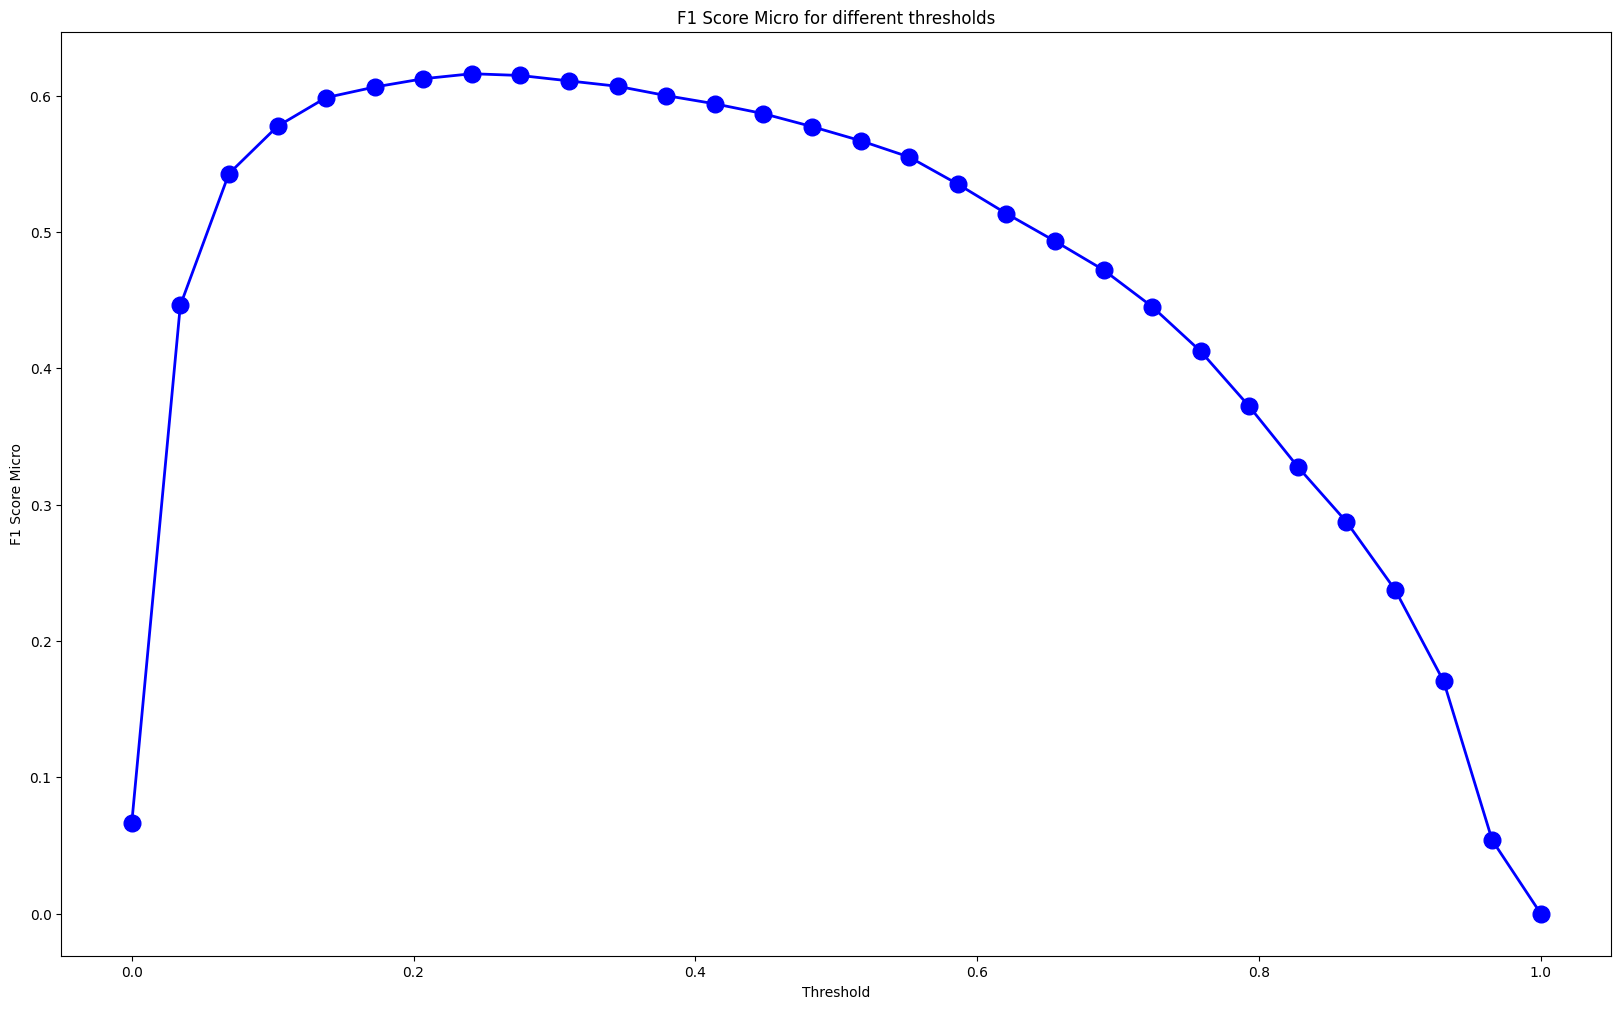

best threshold: 0.24137931034482757
Prediction: ('Novel',)
True label: ('Novel',)
Jaccard value: 1.0

Prediction: ("Children's literature",)
True label: ("Children's literature",)
Jaccard value: 1.0

Prediction: ('Fiction', 'Novel')
True label: ('Fiction', 'Novel')
Jaccard value: 1.0

Prediction: ('Non-fiction',)
True label: ('Non-fiction',)
Jaccard value: 1.0

Prediction: ("Children's literature", 'Fiction', 'Young adult literature')
True label: ("Children's literature", 'Fiction', 'Young adult literature')
Jaccard value: 1.0



In [56]:
# Flatten the outputs and labels lists
all_probabilities_ = np.vstack(all_probabilities)
all_true_labels_ = np.vstack(all_true_labels)
# display first label
print(all_true_labels_[2])
# decode the labels
all_true_labels_decoded = mlb.inverse_transform(all_true_labels_)
print(all_true_labels_decoded[2])


# Determine the predicted labels based on the threshold
threshold = 0.24
all_predictions = (all_probabilities_ > threshold).astype(int)
# display first 5 predictions
print(all_predictions[2])
# decode the predictions
all_predictions_decoded = mlb.inverse_transform(all_predictions)
print(all_predictions_decoded[2])

# Calculate the micro-averaged accuracy
micro_f1 = f1_score(all_true_labels_, all_predictions, average='micro')

print(f'micro accuracy: {micro_f1}')

# Create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 30)
f1_scores = []
for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    predictions = (all_probabilities_ > threshold).astype(int)
    f1_scores.append(f1_score(all_true_labels_, predictions, average='micro'))

# Plot the data
plt.figure(figsize=(20, 12))
plt.plot(thresholds, f1_scores, marker='o', color='blue', linewidth=2, markersize=12)
plt.title('F1 Score Micro for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')
plt.show()

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'best threshold: {best_threshold}')

# calculate jaccard value for each prediction with its true label
jaccard_list = []
for i in range(len(all_true_labels_)):
    jaccard_list.append(jaccard_score(all_true_labels_[i], all_predictions[i], average='micro'))

# get the index of the top 5 highest jaccard value and print its decoded prediction and true label
top_5_highest_jaccard = np.argsort(jaccard_list)[-5:]
for i in top_5_highest_jaccard:
    print(f"Prediction: {all_predictions_decoded[i]}")
    print(f"True label: {all_true_labels_decoded[i]}")
    print(f"Jaccard value: {jaccard_list[i]}")
    print()

# get the index of the top 5 lowest jaccard value and print its decoded prediction and true label
top_5_lowest_jaccard = np.argsort(jaccard_list)[:5]
for i in top_5_lowest_jaccard:
    print(f"Prediction: {all_predictions_decoded[i]}")
    print(f"True label: {all_true_labels_decoded[i]}")
    print(f"Jaccard value: {jaccard_list[i]}")
    print()


## Visualize Trainings-/Test Loss

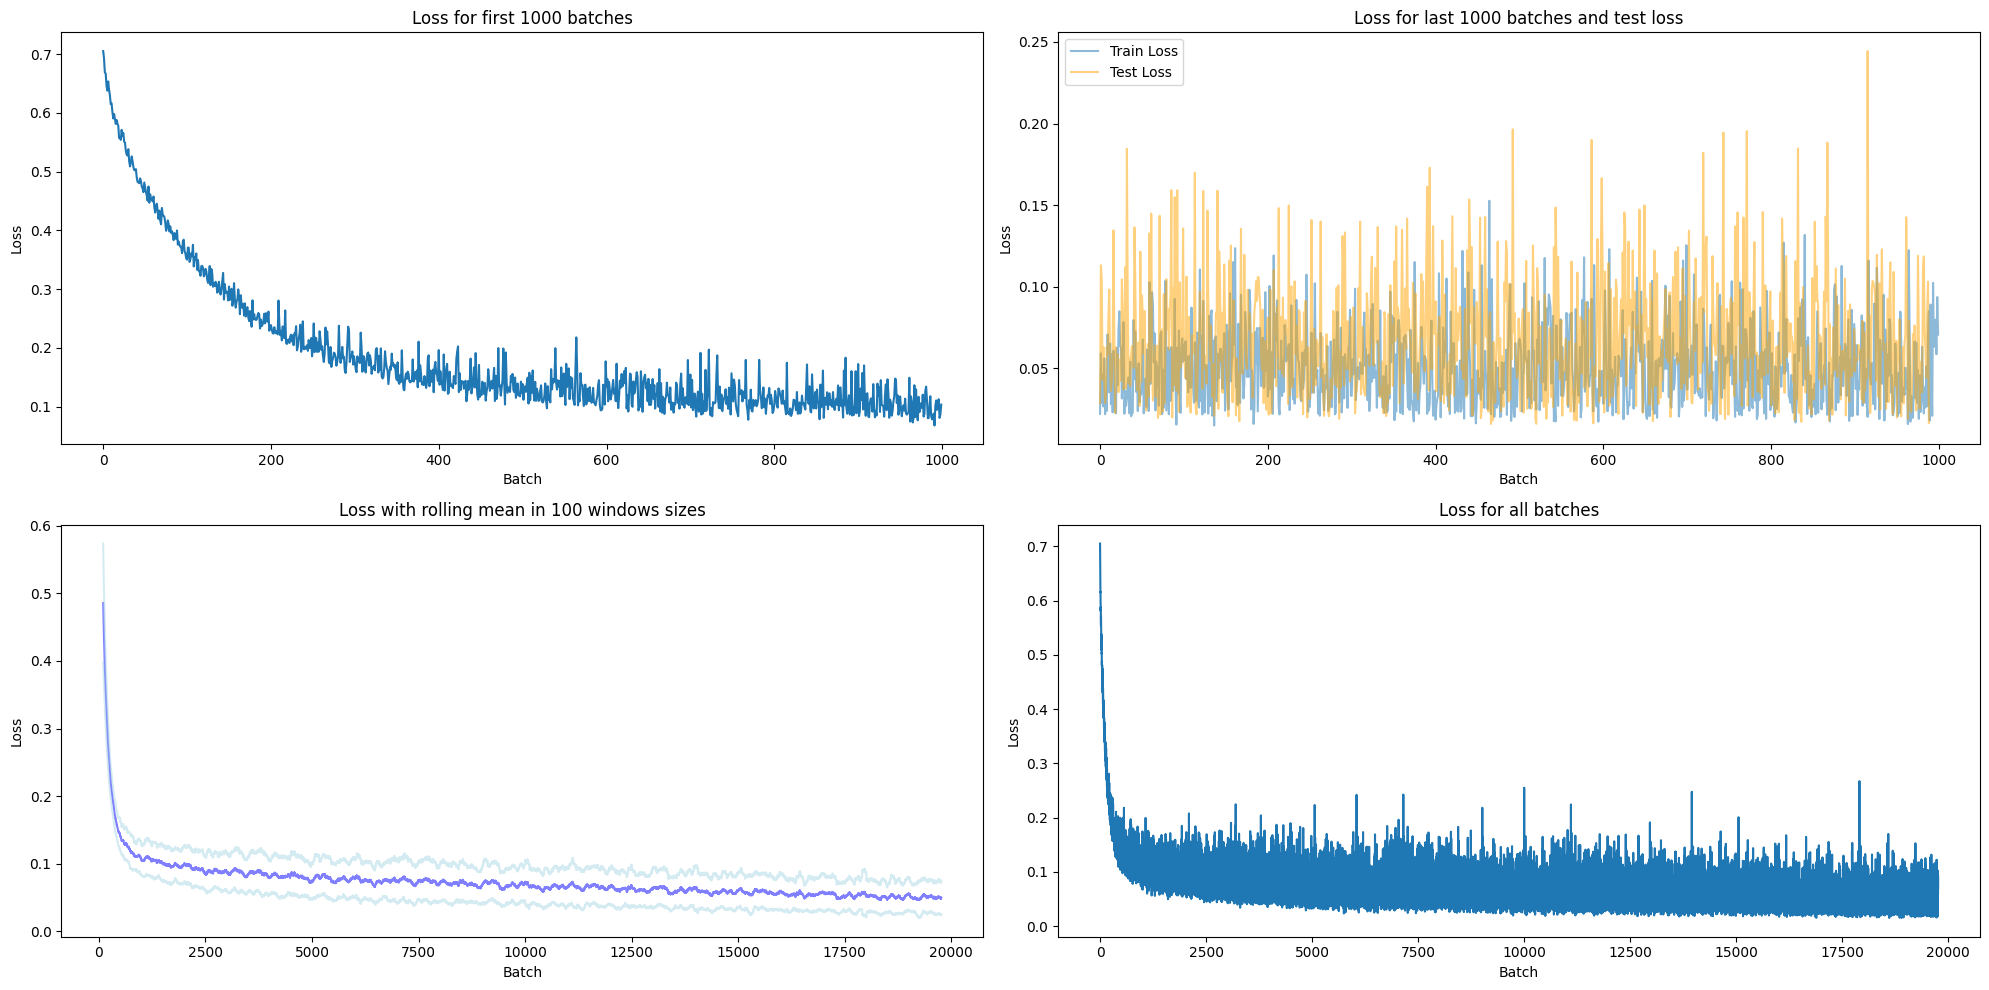

In [44]:
# Create 4 subplots in one figure for the list_loss visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].plot(loss_list[:1000])
axes[0, 0].set_title('Loss for first 1000 batches')
axes[0, 0].set_xlabel('Batch')
axes[0, 0].set_ylabel('Loss')

# plot for the last 1000 batches
axes[0, 1].plot(loss_list[-1000:], alpha = 0.5)
axes[0, 1].plot(test_loss_list, color = "orange", alpha = 0.5)
axes[0, 1].legend(['Train Loss', 'Test Loss'])
axes[0, 1].set_title('Loss for last 1000 batches and test loss')
axes[0, 1].set_xlabel('Batch')
axes[0, 1].set_ylabel('Loss')

# plot with rolling mean plus std in 100 windows sizes
axes[1, 0].plot(pd.Series(loss_list).rolling(100).mean(), color = 'blue', alpha=0.5)
axes[1, 0].plot(pd.Series(loss_list).rolling(100).mean() + pd.Series(loss_list).rolling(100).std(), color='lightblue', alpha=0.5)
axes[1, 0].plot(pd.Series(loss_list).rolling(100).mean() - pd.Series(loss_list).rolling(100).std(), color='lightblue', alpha=0.5)
axes[1, 0].set_title('Loss with rolling mean in 100 windows sizes with std')
axes[1, 0].set_xlabel('Batch')
axes[1, 0].set_ylabel('Loss')

# plot everything
axes[1, 1].plot(loss_list)
axes[1, 1].set_title('Loss for all batches')
axes[1, 1].set_xlabel('Batch')
axes[1, 1].set_ylabel('Loss')

plt.tight_layout()
plt.show()



## Loading Fine Tuned Model

Hier testen wir, ob wir unser fine tunetes Model einlesen können und mit den gleichen Testdaten die gleichen Resultate erzielen.    
Dies gibt uns die Möglichkeit, beim durchlaufen des Notebooks nicht immer das Model neu zu trainieren.


In [20]:
# Assume you have a CUDA-capable GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load your model
fine_tuned_model = AutoModelForSequenceClassification.from_pretrained('models/model-test')

# Move your model to the device
fine_tuned_model.to(device)

# Move model to evaluation mode
fine_tuned_model.eval()

# Initialize sigmoid function
sigmoid = Sigmoid()

# Store probabilities and true labels
all_probabilities = []
all_true_labels = []

# No need to track gradients for validation
with torch.no_grad():
    for batch in tqdm(test_loader):  # Replace with your data loader
        # Unpack batch and move to the device
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        # Forward pass, get logits
        outputs = fine_tuned_model(input_ids, attention_mask=attention_mask)
        
        # Apply sigmoid to logits
        probabilities = sigmoid(outputs.logits)
        
        # Move probabilities and labels back to CPU if on GPU
        all_probabilities.append(probabilities.cpu().numpy())
        all_true_labels.append(labels.cpu().numpy())

100%|██████████| 989/989 [01:36<00:00, 10.23it/s]


micro accuracy: 0.5907122232916265


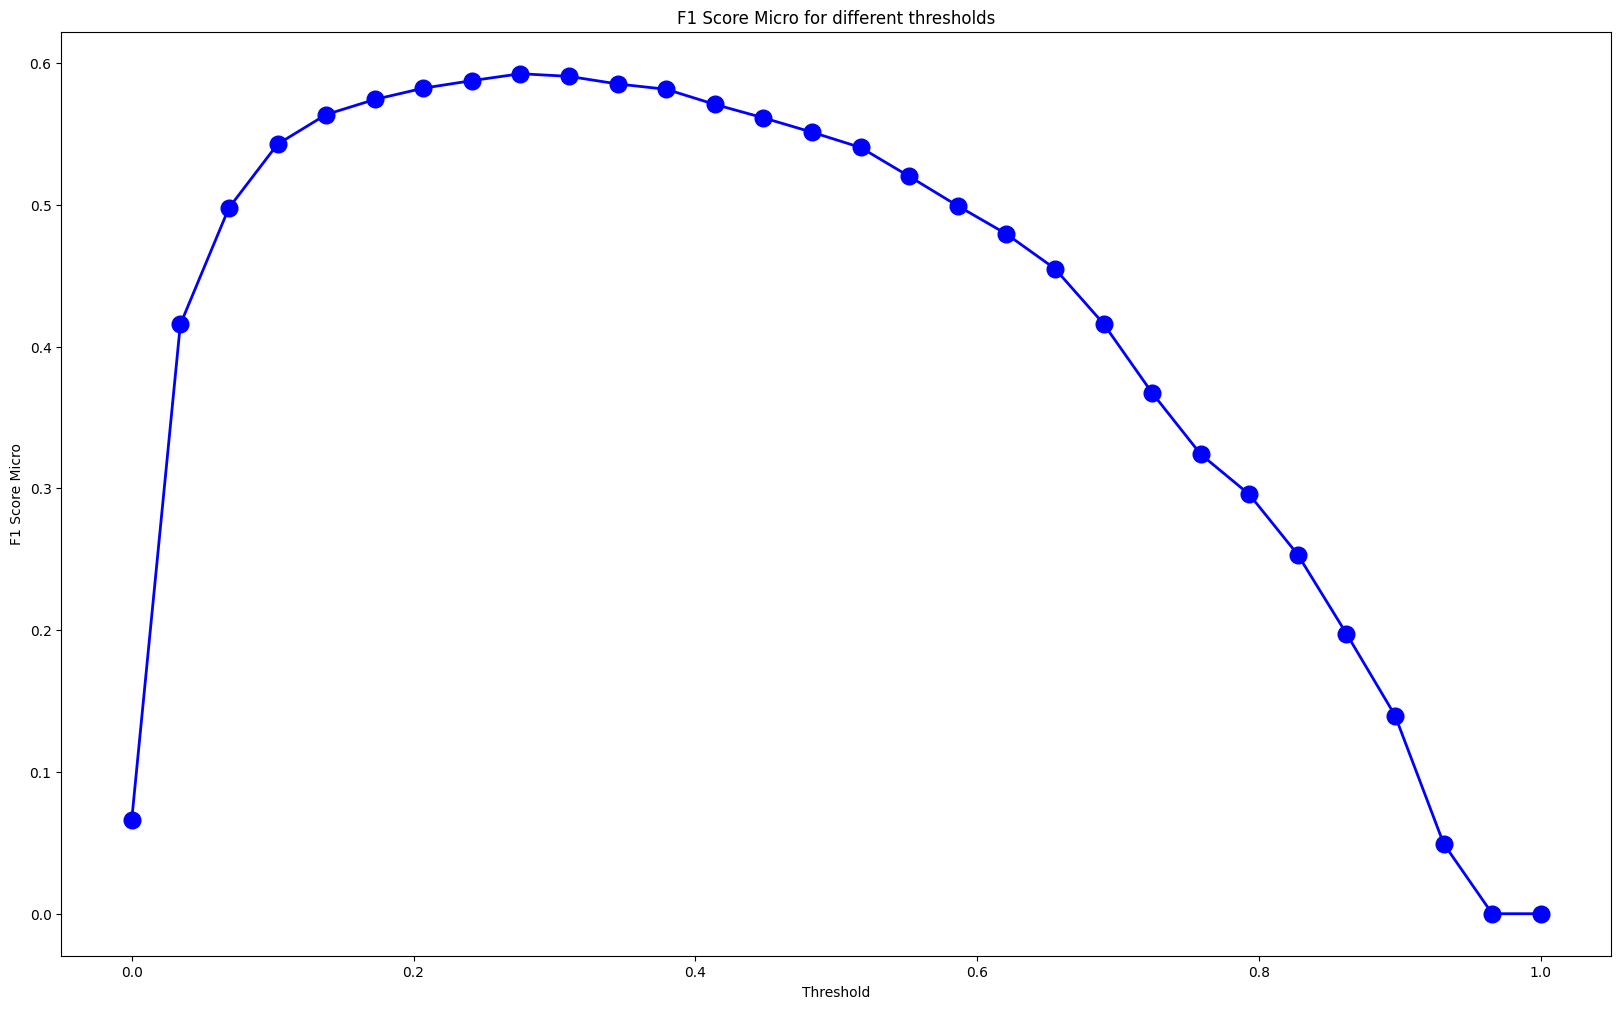

In [21]:
# Flatten the outputs and labels lists
all_probabilities_ = np.vstack(all_probabilities)
all_true_labels_ = np.vstack(all_true_labels)

# Determine the predicted labels based on the threshold
threshold = 0.3
all_predictions = (all_probabilities_ > threshold).astype(int)

# Calculate the micro-averaged accuracy
micro_f1 = f1_score(all_true_labels_, all_predictions, average='micro')

print(f'micro accuracy: {micro_f1}')

# Create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 30)
f1_scores = []
for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    predictions = (all_probabilities_ > threshold).astype(int)
    f1_scores.append(f1_score(all_true_labels_, predictions, average='micro'))

# Plot the data
plt.figure(figsize=(20, 12))
plt.plot(thresholds, f1_scores, marker='o', color='blue', linewidth=2, markersize=12)
plt.title('F1 Score Micro for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')
plt.show()